## Import

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import re
import subprocess
import timeit
import numpy as np
import scipy as sp
import sympy as sy
import pandas as pd
import itertools
import random
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms
import torch.nn.functional as F
from collections import OrderedDict

from torch.utils.data import SubsetRandomSampler

# functions to play animations
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

import modelarchy
import helper

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Download and load the training data
trainset = datasets.MNIST('/home/q1park/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('/home/q1park/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [3]:
# Hyperparameters for our network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                      ('relu1', nn.ReLU()),
                      ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                      ('relu2', nn.ReLU()),
                      ('output', nn.Linear(hidden_sizes[1], output_size)),
                      ('softmax', nn.LogSoftmax(dim=1))]))
# Define the loss
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

print(model);

Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
  (softmax): LogSoftmax()
)


In [4]:
# Set biases to all zeros and weights to random normal with standard dev = 0.01
#for ilayer in iter(model):
#    if re.match(r'Linear', str(ilayer)):
#        ilayer.bias.data.fill_(0);
#        ilayer.weight.data.normal_(std=0.01);
#pass;

In [5]:
epochs = 2
steps = 0

train_losses, test_losses = [], []

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Clear the gradients, do this because gradients are accumulated
        optimizer.zero_grad()
        
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        
        # Take an update step and few the new weights
        optimizer.step()
        
        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in testloader:
                
                images = images.view(images.shape[0], -1)
                logps = model.forward(images)
                test_loss += criterion(logps, labels)
                
                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/2..  Training Loss: 1.863..  Test Loss: 1.169..  Test Accuracy: 0.749
Epoch: 2/2..  Training Loss: 0.793..  Test Loss: 0.570..  Test Accuracy: 0.847


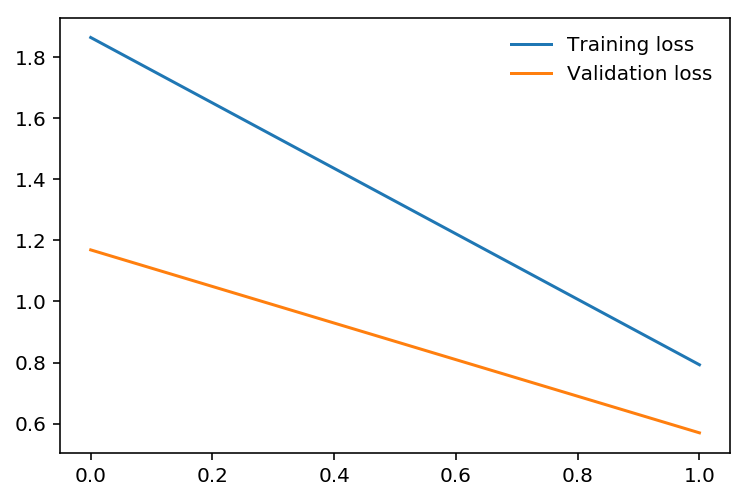

In [6]:
plt.plot(train_losses, label='Training loss');
plt.plot(test_losses, label='Validation loss');
plt.legend(frameon=False);

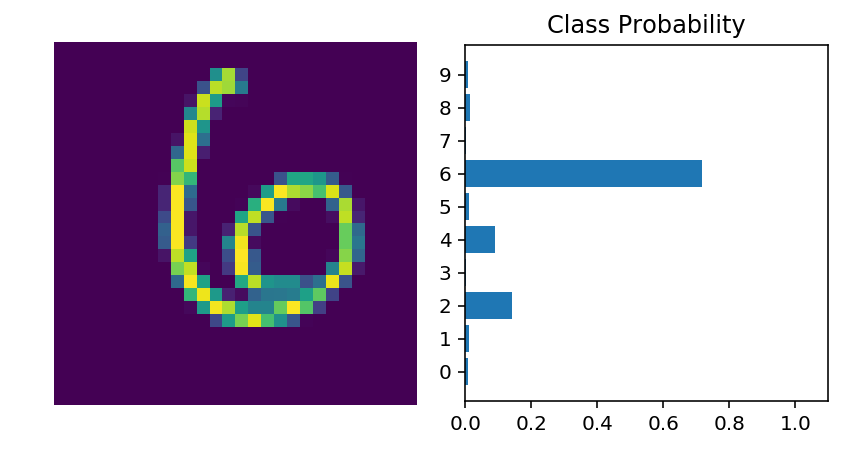

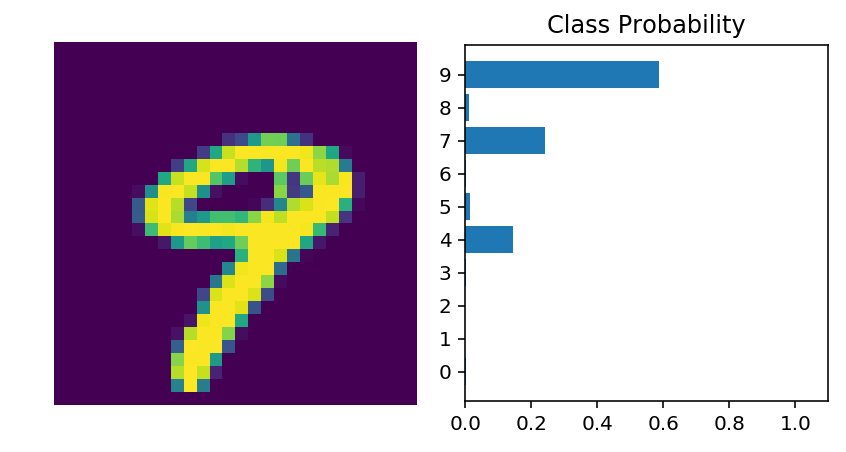

In [7]:
model.eval();

modelarchy.view_probability(model, testset, 100, version="MNIST");
modelarchy.view_probability(model, testset, 9, version="MNIST");